## Класификационни и регресионни дървета

In [1]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

Днес: decision trees

Преди това: да си припомним малко от предния път.

# NumPy и векторизация

Повечето операции в NumPy работят с така наречената векторизация. Това по-лесно се илюстрира с пример:

In [2]:
np.array([1, 2, 3, 4]) * 5

array([ 5, 10, 15, 20])

In [3]:
np.array([1, 2, 3]) * np.array([3, 4, 5])

array([ 3,  8, 15])

In [4]:
np.array([8, 3, 4, 1, 9, 4]) > 4

array([ True, False, False, False,  True, False], dtype=bool)

In [5]:
(np.array([8, 3, 4, 1, 9, 4]) > 4).astype(float)

array([ 1.,  0.,  0.,  0.,  1.,  0.])

In [6]:
np.array([10, 20, 30])[np.array([1, 0, 2, 0, 1])]

array([20, 10, 30, 10, 20])

Основната цел е да не ни се налага да пишем `for` цикли. Като допълнение – векторизираните операции в NumPy работят много по-бързо от цикъла в Python, който бихме написали.

# LabelEncoder

Ако има категорийни данни (например низове), може да ползваме `LabelEncoder` да ги заменим с числа:

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(["red", "green", "red", "blue", "red", "green"])

colors = ["green", "green", "blue"]

print("transofrmed:", encoder.transform(["green", "green", "blue"])) 
print("inverse:    ", encoder.inverse_transform([0, 1, 2]))

transofrmed: [1 1 0]
inverse:     ['blue' 'green' 'red']


# OneHotEncoder

Може да кодираме категории с label encoder, когато в категориите има някакъв естествен ред (напр. 4 е по-голямо от 2). Ако няма такъв ред обаче, на най-добре е да ползваме one-hot – така създаваме по един фийчър за всяка категория, който има стойности 0 или 1.

In [8]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoder.fit([[0], 
             [1], 
             [0], 
             [2]])

print(encoder.transform([[0], [1], [1], [2], [0]]).toarray())

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]


Но да се върнем към днешната тема!

Нека генерираме синтетичен dataset подходящ за класификация. Може да погледнете [документацията](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) за значението на параметрите:

In [9]:
X, y = make_classification(n_samples=100,
                           n_features=2,
                           n_redundant=0, 
                           n_clusters_per_class=2, 
                           random_state=123)

`X` ще съдържа матрица от точки (всеки ред е точка с два координата), а `y` ще съдържа класа на всяка точка (0 или 1):

In [10]:
print(X[:4])
print(y[:4])

[[-0.01032243 -0.80566819]
 [-1.10293659  2.21661117]
 [-1.90795358 -0.20839902]
 [ 0.53115524  2.2762704 ]]
[1 0 0 1]


Нека начертаем точките и техните класове в равнината:

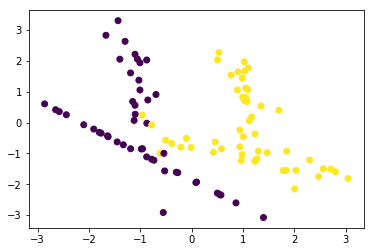

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y);

Това е една функция, която ще начертае decision boundary на decision tree (ще оцвети фона спрямо как класификатора ще определи дадена точка):

In [12]:
# Plotting decision regions adapted from 
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

def plot_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    f, ax = plt.subplots(figsize=(10, 8))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    
    plt.show()

Нека тренираме класификатор:

In [13]:
classifier = DecisionTreeClassifier().fit(X, y)
print(classifier.score(X, y))

1.0


Както виждаме, той успява да намери решение, което винаги класифицира правилно. Вероято прави голям overfitting. Да начертаем decision boundary-то:

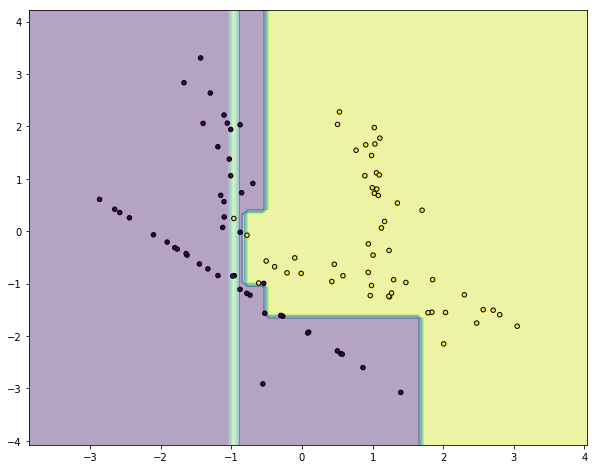

In [14]:
plot_boundary(classifier, X, y)

От графиката изглежда че има overfitting – например има вертикалната ивица окола $x_0 = -1$ се класифицира изцяло като жълта, защото има една точка от този клас. По-вероятно е това да е някаква аномалия и да бихме искали да я сметнем за точка от другия клас.

Бихме могли да регуляризираме с `min_samples_split`:

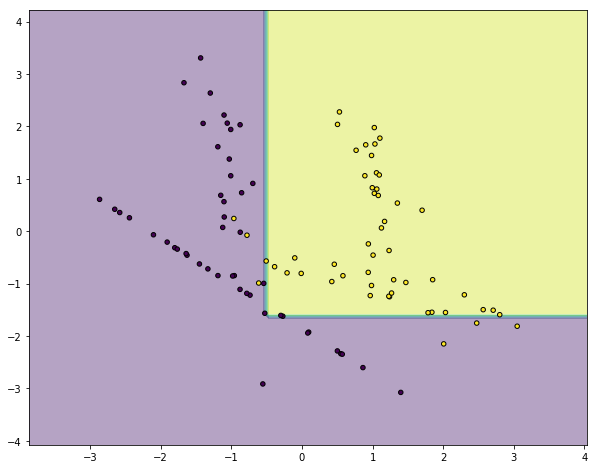

In [15]:
classifier = DecisionTreeClassifier(min_samples_split=50).fit(X, y)
plot_boundary(classifier, X, y)

Тук получаваме по-прост модел, който естествено игнорира някои точки, но поне не overfit-ва.

Нека начертаем дървото, което алгоритъма е открил:

In [16]:
import graphviz

# За да изпълните този код ще се нуждаете от graphviz библиотеката и съответния пакет за нея в python.
#
# На macOS това става със:
#
#  brew install graphviz
#  pip install graphviz
#
# На други операционни системи трябва да замените първия ред с каквото ви е нужно (apt-get, yum, т.н.)

def draw_decision_tree(classifier):
    dot_data = tree.export_graphviz(classifier, out_file=None) 
    graph = graphviz.Source(dot_data) 
    graph.render("tree") 

    dot_data = tree.export_graphviz(classifier, out_file=None, 
                             feature_names=np.array(['X_0 Vertical', 'X_1 Horizontal']),  
                             class_names=np.array(['Class_0', 'Class_1']),  
                             filled=True, rounded=True,  
                             special_characters=True)

    return graphviz.Source(dot_data) 

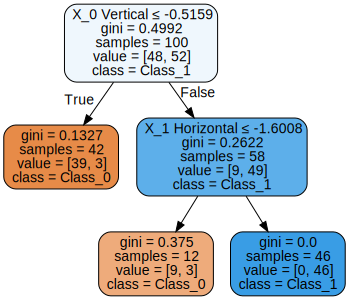

In [17]:
draw_decision_tree(classifier)

Това е дървото на алгоритъма с `max_samples_split=50`. Може да видите няколко неща.

Първо, алгоритъма се опитва да намери дърво от `if`-ове с които да отговори на класификационния въпрос. Първоначално сравнява $x_0$ (първия feature в `X` с $-0.5159$). Ако е по-малко, отговаря с оранжевия клас. Ако е по-голямо, сравнява $x_1$ с $-1.6008$ и на базата на резултата отговаря взема решение. Това съответства на правоъгълния в опростения алгоритъм.

Във `samples` може да видите колко точки остават след вземането на решение. Например, първия възел ($x_0 < 0.5159$) ще раздели 100-те точки на два групи, една с 42 и друга с 58. Във `value` може да видите по колко точки има от всеки клас. Например, в лявото разклонение след корена на дървото попадаме в ситуация, в която в train set-а има 39 оранжеви и 3 сини и даваме отговор оранжеви (`Class_0`). Алгоритъма би могъл да продължи да разделя дървото, но понеже `samples = 42` е по-малко от `min_samples_split = 50` той спира да строи.

`gini` е параметър, който помага на алгоритъма да прецени какво е най-доброто разпределение да дървото. Ще го разгледаме по-долу.

Нека да видим как ще се справи алгоритъма без регуляризация:

In [18]:
classifier = DecisionTreeClassifier().fit(X, y)

Така изглежда decision boundary-то:

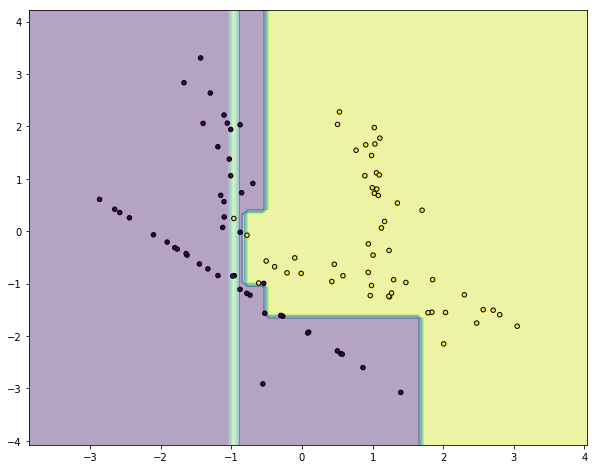

In [19]:
plot_boundary(classifier, X, y)

Така изглежда неговото дърво:

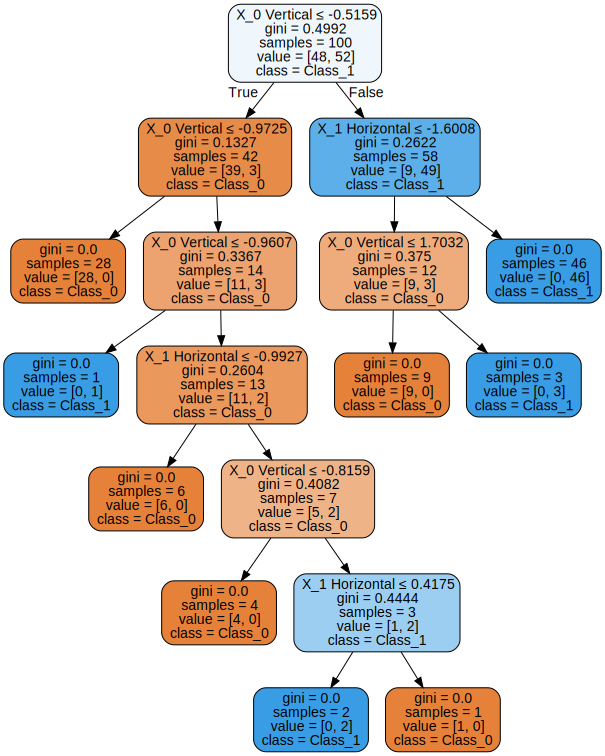

In [20]:
draw_decision_tree(classifier)

Може да видите, че дървото е доста по-сложно, но за сметка на това отгатва train set-а перфектно. Ако проследите стойностите, може да се уверите, че съответства на графиката по-горе.

# В `sklearn` е имплементиран CART алгоритъм. 

## Classification and Regression Trees

L. Breiman, J. Friedman, R. Olshen, and C. Stone. Classification and Regression Trees. Wadsworth, Belmont, CA, 1984

http://scikit-learn.org/stable/modules/tree.html#tree

# Моделът CART е двоично дърво. 

* Всеки елемент от дървото може да има нула, едно или две деца.
* Алгоритъмът работи рекурсивно. 
* Критерии за спиране могат да бъдат:
  * Достигната е абсолютна чистота на елементите в дървото (останали са само един клас данни в последните деца)
  * Достигната е максимална дълбочина на дървото (`max_depth`)
  * Достигнат е минимален брой примери за разделяне (`min_samples_split`)

# Алгоритъмът е алчен (greedy):
* Проверява всяка възможна колона (feature) за всички възможни раздвоявания и избира най-доброто.
* Сложност при трениране: $O(n_{features}n_{samples}\log(n_{samples}))$

Следва малко математика, която не е съществена за разбиране на това какво се случва, но описва картинката една идея по-добре:

# Оценяваща функция:

Оценяващата функция работи, чрез Information Gain:

$$ InformationGain = impurity(parent) - {WeightedAverageBySamplesCount}\sum{impurity(children)}$$

$impurity$ е функция, която измерва "примесите". В алгоритъма могат да се ползват различни функции:

* При класификация
  1. Ентропия (Entropy)
  2. Gini
  3. Неправилна класификация (Misclassification)
* При регресия
  1. Средно аритметично от разликата на квадратите (Mean Squared Error)
  2. Средно аритметично от абсолютната стойност на разликата (Mean Absolute Error)

При предвиждане на нов запис, алгоритъмът се спуска по построеното дърво докато стигне възел без наследници.

* Предвижда средната стойнoст от записите останали в последния елемент при регресия.
* При класификация избира класа представен от мнозинството от записи останали в последния елемент.
* Сложност при предвиждане: $O(\log(n_{samples}))$

# Функции за измерване на примесите (impurity)

## 1. Ентропия

 $entropy = \sum_i{ - p_i  log_2(  p_i )}$
 
 $p_i= \frac{size of class_i}{size of set}$

### Пример 1:

Имаме множество:

```python
['Лъчо', 'Лъчо', 'Стефан', 'Стефан']
```

Лъчо - 2, Стефан - 2

Пропорции:

Лъчо: $\frac{2}{4}$, Стефан: $\frac{2}{4}$

Стойност за Лъчо: 
$$-\frac{2}{4} * log_2(\frac{2}{4})$$
$$-0.5 * -1$$
$$0.5$$

Стефан има същата стойност $0.5$.

Ентропията на множеството е $$entropy=0.5+0.5 = 1.0$$


### Пример 2:

```python
['Круши', 'Круши', 'Круши']
```

Круши - 3

Пропорции:

Круши $\frac{3}{3} = 1$

$$-1 * log_2(1)$$
$$-1 * 0$$
$$entropy=0$$

Ето функция, която измерва това:

In [21]:
def entropy(subset_counts):
    subset_counts = np.array(subset_counts)
    subset_counts_normalized = subset_counts / subset_counts.sum()
    
    entropy = sum([-subset_count * np.log2(subset_count + 0.000000000001) 
                   for subset_count in subset_counts_normalized])
    
    entropy = np.round(entropy, 4)
    print('Entropy for', subset_counts, 'is', entropy)
    return entropy

Обърнете внимание на `+ 0.000000000001` в логаритъма. Мислете за това като хак, с който са си спестим малко сметки за да избегнем смятана на логаритъм от 0.

In [22]:
samples = [[2, 0], [1, 0], [9, 1], [4, 4]]

for sample in samples:
    entropy(sample)

Entropy for [2 0] is -0.0
Entropy for [1 0] is -0.0
Entropy for [9 1] is 0.469
Entropy for [4 4] is 1.0


При два класа ентропията ще е в множеството $\big[0, 1\big]$. Имаме $1$ когато двата класа са равномерно разпределени в множеството и $0$, когато множеството съдържа елементи само от единия вид.

При три или повече класа, функцията няма горна граница:

In [23]:
samples = [[2, 0, 1], [6, 0, 0], [9, 1, 0], [5, 5, 0], [5, 5, 5]]

for sample in samples:
    entropy(sample)

Entropy for [2 0 1] is 0.9183
Entropy for [6 0 0] is -0.0
Entropy for [9 1 0] is 0.469
Entropy for [5 5 0] is 1.0
Entropy for [5 5 5] is 1.585


## 2. Gini

$H(X_m) = \sum_k p_{mk} (1 - p_{mk})$

$p_{mk}$ отново е пропорцията на класа в множеството.

### Пример:

```python
['Лъчо', 'Лъчо', 'Стефан', Стефан']
```

Лъчо - 2, Стефан - 2

Пропорции:

Лъчо: $\frac{2}{4}$, Стефан: $\frac{2}{4}$

Стойност за Лъчо: 
$$\frac{2}{4} * (1 - \frac{2}{4})$$
$$0.5 * 0.5$$
$$0.25$$

Стефан има същата стойност $0.25$.

$$gini=0.25+0.25 = 0.5$$


### Пример 2:

['Круши', 'Круши', 'Круши']

Круши - 3

Пропорции:

Круши $\frac{3}{3} = 1$

$$1 * (1 - 1)$$
$$1 * 0$$
$$gini=0$$

In [24]:
def gini_impurity(subset_counts):
    subset_counts = np.array(subset_counts)
    subset_counts_normalized = subset_counts / subset_counts.sum()
    
    impurity = sum([subset_count * (1 - subset_count) 
                    for subset_count in subset_counts_normalized])
    
    print('Gini impurity for', subset_counts, 'is', impurity)
    return impurity

In [25]:
samples = [[2, 0], [1, 0], [9, 1], [4, 4]]

for sample in samples:
    gini_impurity(sample)

Gini impurity for [2 0] is 0.0
Gini impurity for [1 0] is 0.0
Gini impurity for [9 1] is 0.18
Gini impurity for [4 4] is 0.5


In [26]:
samples = [[2, 0, 1], [6, 0, 0], [9, 1, 0], [5, 5, 0], [5, 5, 5]]

for sample in samples:
    gini_impurity(sample)

Gini impurity for [2 0 1] is 0.444444444444
Gini impurity for [6 0 0] is 0.0
Gini impurity for [9 1 0] is 0.18
Gini impurity for [5 5 0] is 0.5
Gini impurity for [5 5 5] is 0.666666666667


## 3. Неправилна класификация (Misclassification)

$H(X_m) = 1 - \max(p_{mk})$


In [27]:
def missclassification_impurity(subset_counts):
    subset_counts = np.array(subset_counts)
    subset_counts_normalized = subset_counts / subset_counts.sum()
    
    impurity = 1 - max(subset_counts_normalized)
    
    print('Misclassification impurity for', subset_counts, 'is', impurity)
    return impurity

In [28]:
samples = [[2, 0], [1, 0], [9, 1], [4, 4]]

for sample in samples:
    missclassification_impurity(sample)

Misclassification impurity for [2 0] is 0.0
Misclassification impurity for [1 0] is 0.0
Misclassification impurity for [9 1] is 0.1
Misclassification impurity for [4 4] is 0.5


In [29]:
samples = [[2, 0, 1], [6, 0, 0], [9, 1, 0], [5, 5, 0], [5, 5, 5]]

for sample in samples:
    missclassification_impurity(sample)

Misclassification impurity for [2 0 1] is 0.333333333333
Misclassification impurity for [6 0 0] is 0.0
Misclassification impurity for [9 1 0] is 0.1
Misclassification impurity for [5 5 0] is 0.5
Misclassification impurity for [5 5 5] is 0.666666666667


Когато конструирате дърво, може да подадете критерий коя функция да се ползва. Това е параметъра `criterion`. scikit-learn поддържа само `gini` и `entropy`. Повече информация може да намерите в документацията:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

На всяка стъпка алгоритъма се опитва да намери неравенство, което да оптимизира information gain-а. Той се получава по следната формула:

$ InformationGain = impurity(parent) - \sum_k{p_{mk}}{impurity(children)}$

Може да видим различните резултати, които бихме имали при различните функции за оценка на примесите:

In [30]:
def information_gain(subsets, parent_impurity=1, f=entropy):
    total_count = sum(sum(i) for i in subsets)
    print("Total count:", total_count)
    
    subsets_impurity = sum((sum(subset) / total_count * f(subset) for subset in subsets))
    gain = parent_impurity - subsets_impurity
    print("Information gain:", gain)
    return gain

In [31]:
subsets = [[2, 1], [1]]
for f in [entropy, gini_impurity, missclassification_impurity]:
    information_gain(subsets, parent_impurity=1, f=f); 
    print();

Total count: 4
Entropy for [2 1] is 0.9183
Entropy for [1] is -0.0
Information gain: 0.311275

Total count: 4
Gini impurity for [2 1] is 0.444444444444
Gini impurity for [1] is 0.0
Information gain: 0.666666666667

Total count: 4
Misclassification impurity for [2 1] is 0.333333333333
Misclassification impurity for [1] is 0.0
Information gain: 0.75



In [32]:
subsets = [[2], [2]]
for f in [entropy, gini_impurity, missclassification_impurity]:
    information_gain(subsets, parent_impurity=1, f=f); 
    print();

Total count: 4
Entropy for [2] is -0.0
Entropy for [2] is -0.0
Information gain: 1.0

Total count: 4
Gini impurity for [2] is 0.0
Gini impurity for [2] is 0.0
Information gain: 1.0

Total count: 4
Misclassification impurity for [2] is 0.0
Misclassification impurity for [2] is 0.0
Information gain: 1.0



In [33]:
gini_impurity([48, 52])
gini_impurity([9, 49])
gini_impurity([39, 3])
gini_impurity([0, 46]);

Gini impurity for [48 52] is 0.4992
Gini impurity for [ 9 49] is 0.262187871581
Gini impurity for [39  3] is 0.132653061224
Gini impurity for [ 0 46] is 0.0


До тук с математиката. Не е нужно да запомните всичко, но ако ви се налага да дебъгвате какво е открил алгоритъма, това може да ви помогне да си го обясните.

# Плюсове на decision tree 
* Дървото е лесно за интерпретация.
* Лесно се справя с ирелевантни feature-и (gain = 0).
* Може да се справи с липсващи данни (макар и не за текущата имплементация в sklearn).
* Компактно представяне на модела.
* Бърз при предсказване (линеен на дълбочината на дървото).
* Може да прави класификация с повече класове без допълнителни трикове.
* Лесен за използване и дава добри резултати с малко експерименти.

# Минуси

* Разделя атрибутите само по осите. 
* Алчен (greedy) - може да не открие най-доброто дърво.
* Експоненциално нарастване на възможните дървета.
* Овърфитва силно.

## Random Forest

За да се справим с проблемите на decision tree обикновено ползваме нещо, наречено random forest. То работи по следния начин:

* Генерира много на брой дървета (10, 100, 1000, т.н.).
* Всяко дърво е генерирано с различни критерии от останалите (подмножество на данните, подмножество на feature-ите и т.н.).
* За да се отговори на въпрос, задаваме го на всички дървета и вземаме най-популярния отговор.

Ето някои от причините това да работи по-добре:

* Индивидуалните дървета ще правя overfitting, но по различен начин. Осредненият резултат между тях би трябвало да бъде по-регуляризиран.
* Ако има аномалии в данните, те ще участват в по-малък брой дървета, съответно по-малко дървета ще overfit-ват.
* Вариацията в кои feature се ползват ще изследва различни начини да отговорим на въпроса и докато всеки ще прави грешки, по-малко вероятно е всички да правят едни и същи грешки.

В scikit-learn ползваме random forest по следния начин:

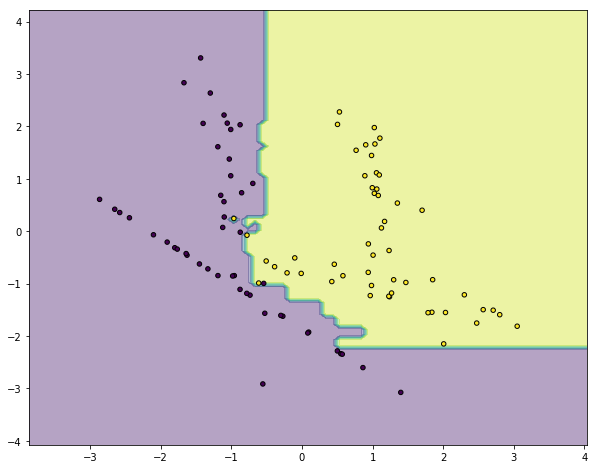

In [34]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=23).fit(X, y) # без натройка на параметрите
plot_boundary(classifier, X, y)

(подали сме `random_state=23` за да получаваме детерминистичен отговор – ако промените параметъра ще бъде намерена друга гора, което ще прави генерирането на едни и същи графики в този notebook трудно)

## Параметри за RF:

* `n_estimators` – брой дървета (10, 100, 1000)
* `criterion` – за всички дървета (gini, entropy)
* `max_features` – колко feature да се пробват при търсене на най-добро разделяне. По подразбиране е `sqrt(n_features)`, като са различни при всяко ново търсене.
* `max_depth` – максимална дълбочина на дърветата.
* `min_samples_split` – минимален брой семпли за да може да се раздели възела
* `bootstrap` – втори параметър за случайност - random sampling with replacement. Тегли същия брой семпли като оригиналния сет, но може да изтегли един елемен няколко пъти (и да не изтели друг)
* `n_jobs` – тренира по няколко дървета едновременно, но използва повече памет
* `random_state` – за възпроизведими експерименти

Ето и две произволни дървета, без фиксиран `random_state`:

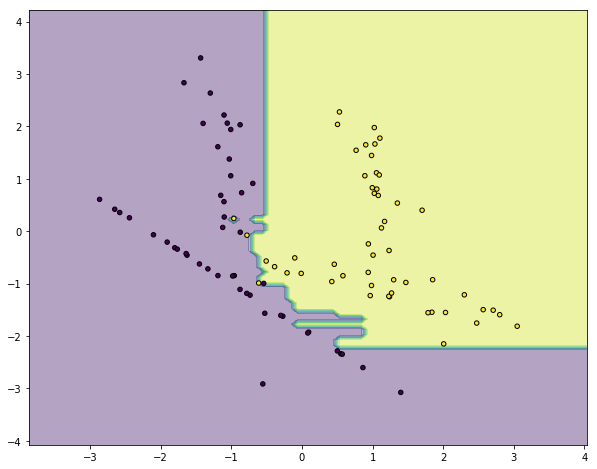

In [35]:
classifer = RandomForestClassifier().fit(X, y)
plot_boundary(classifer, X, y)

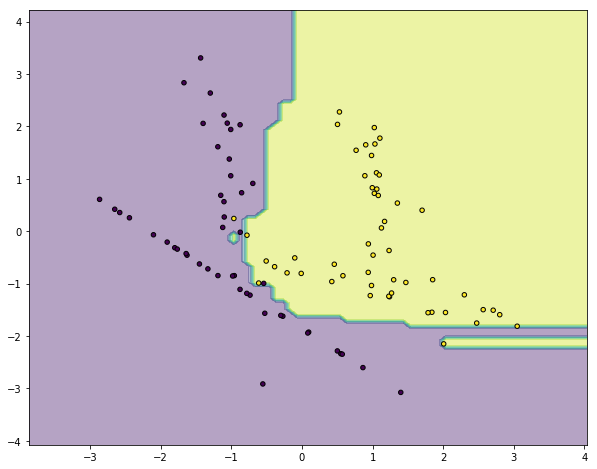

In [36]:
classifer = RandomForestClassifier().fit(X, y)
plot_boundary(classifer, X, y)

# Значимост на feature-ите в random forest

Сходно на теглата на параметрите при линейни модели, random forest може да ви каже кои feature-а намира за най-значими (т.е. носят най-много информация).

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_forest_importances_001.png)

Може да видите повече тук:
http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

### Прочетете документацията:
* http://scikit-learn.org/stable/modules/tree.html
* http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html